# Vanilla Head Pose Tracking
This notebook contains the instructions for the first vanilla version of our head pose tracking algorithm. It simply loads the fast.ai pre-trained ImageNet model and trains it on the BIWI Kinect Headpose Dataset. 

Source: fast.ai's lesson3-head-pose.ipynb notebook

## Installation
The following pip commands need to be run the very first time you run the notebook. They install the necessary packages for running the code. 

Source: The instructions come from [here](https://gist.github.com/gilrosenthal/58e9b4f9d562d000d07d7cf0e5dbd840) and [here](https://forums.fast.ai/t/importerror-cannot-import-name-as-tensor/25295/4).

In [0]:
# !pip install fastai
# !apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
# !pip install Pillow==4.0.0
# !pip install image
# !pip install torchtext==0.2.3

## Import
The following cells import the necessary modules for running a notebook with fast.ai. They need to be run every time the notebook starts.

In [0]:
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
import torch
from google.colab import files

In [0]:
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Getting and converting the data
The following cells download the data and format it correctly

In [0]:
data_path = untar_data(URLs.BIWI_HEAD_POSE)

In [6]:
cal = np.genfromtxt(data_path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg'

In [0]:
def img2txt_name(f): return data_path/f'{str(f)[:-7]}pose.txt'

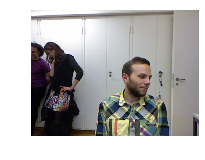

In [10]:
img = open_image(data_path/fname)
img.show()

In [11]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [13]:
get_ctr(fname)

tensor([263.9104, 428.5814])

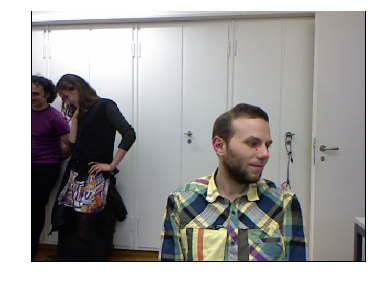

In [14]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Load and View Data
Now whtat we have formatted the data correctly, we can create the dataset that will be the input for the pretrained network

In [0]:
data = (PointsItemList.from_folder(data_path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

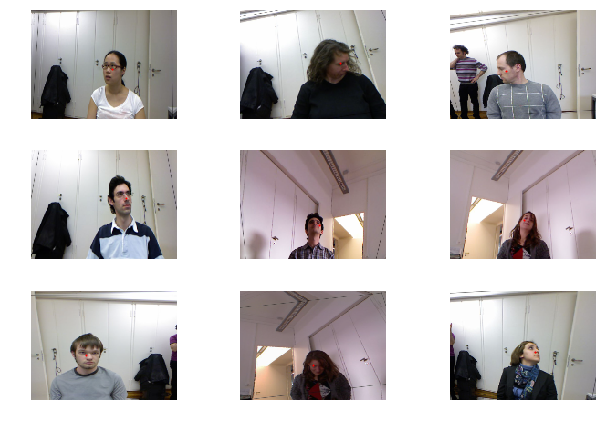

In [17]:
data.show_batch(3, figsize=(9,6))

## Train Model
We are now ready to train the model. Here we are using ResNet-34.

In [18]:
learn = create_cnn(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:03, 22882646.63it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02


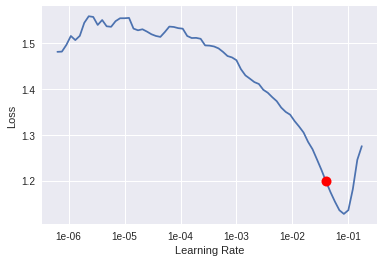

In [19]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 3.98e-2

In [22]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss
1,0.006250,0.001402
2,0.006335,0.000457
3,0.004514,0.000682
4,0.002189,0.000465
5,0.001301,0.000113


In [0]:
 learn.save('stage-1')

In [0]:
learn.load('stage-1');

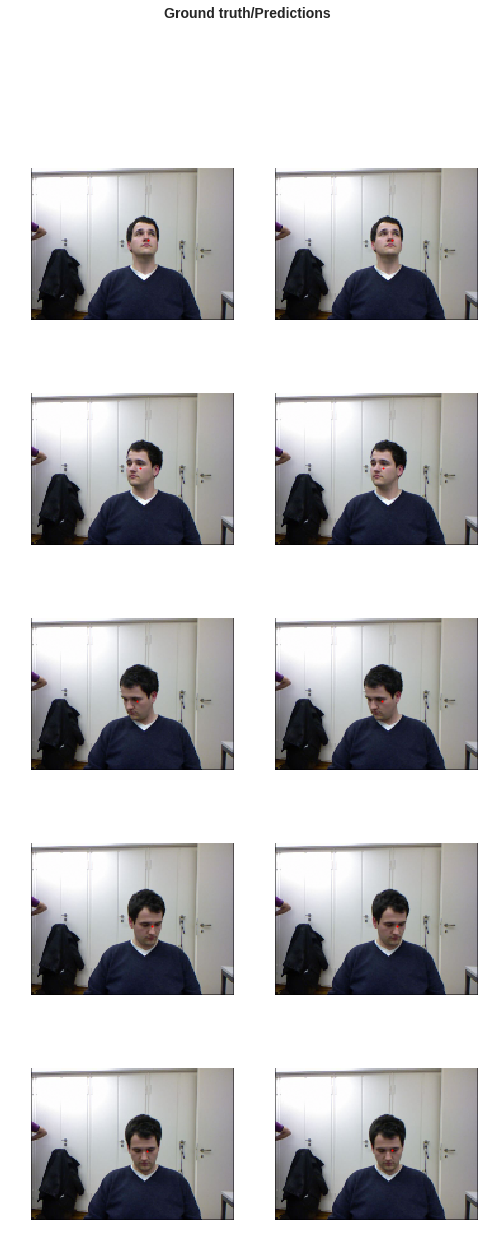

In [25]:
learn.show_results()

## Data Augmentation
Some additional data augmentation was used see how well the model works in other situations

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

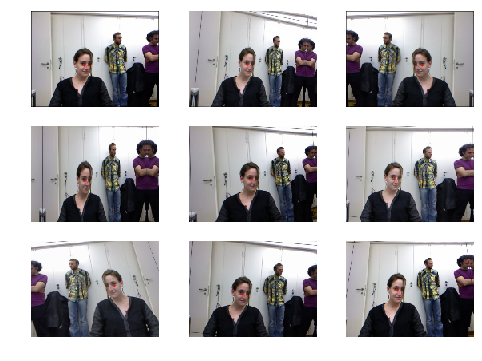

In [0]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))

## Export Model
Now we want to export the model in a format that can be used by a web application.

In [0]:
learn.export()

In [0]:
defaults.device = torch.device('cpu')

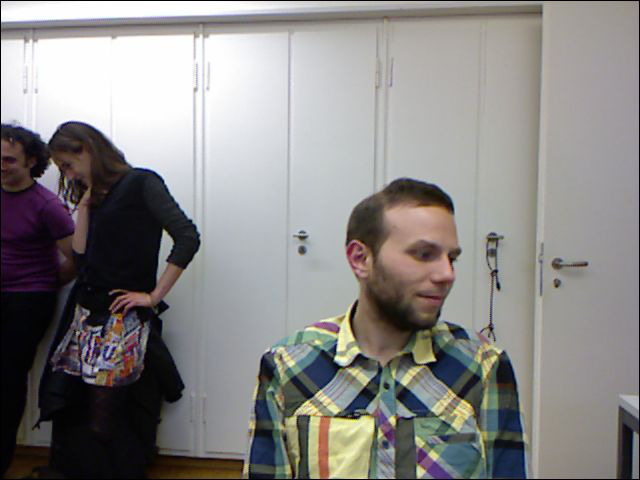

In [29]:
img = open_image(data_path/fname)
img

In [0]:
learn = load_learner(data_path)
files.download(data_path/'export.pkl')

In [0]:
ips, _, _ = learn.predict(img.apply_tfms(None, size=(120,160)))

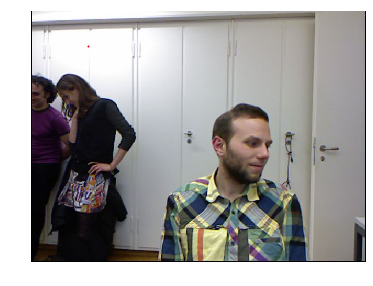

In [33]:
img.show(y=ips, figsize=(6, 6))